#### CPI, PCE 지표를 Investing 사이트에서 크롤링하여 변화추이를 chart에 같이 표시해보자
------------------------------------------------------------------

In [2]:
!pip install matplotlib
!pip install selenium
!pip install webdriver-manager

     ---------------------------------------- 0.0/249.8 kB ? eta -:--:--
     ------------------------------------- 249.8/249.8 kB 16.0 MB/s eta 0:00:00
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)


```
PCE :  https://kr.investing.com/economic-calendar/pce-price-index-906
CPI :  https://kr.investing.com/economic-calendar/cpi-733
```

In [127]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import re
from  datetime import date, timedelta
import time

from selenium import webdriver
from selenium.webdriver.chrome.service import Service    
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
# 크롬 드라이버 자동 업데이트
from webdriver_manager.chrome import ChromeDriverManager 

In [128]:
# matplotlib 에서 한글이 깨진다. 한글폰트 세팅이 필요함
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = r"C:\Windows\Fonts\H2GTRM.TTF"
# font_path = r"C:\Users\swkao\AppData\Local\Microsoft\Windows\Fonts\D2CodingBold-Ver1.3.2-20180524-ligature.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 마이너스 깨짐현상
mpl.rcParams['axes.unicode_minus'] = False

In [129]:
# PCE 데이터에 접근

service=Service(executable_path=ChromeDriverManager().install())
chrome_options = Options()
# headless 옵션 (백그라운드작업)
chrome_options.add_argument("headless")
chrome_options.add_argument("ignore-certificate-errors")
driver = webdriver.Chrome(service=service, options=chrome_options)
# driver = webdriver.Chrome(service=service)
# 해당 웹페이지 열기
driver.implicitly_wait(5) # 웹페이지 로딩 될때까지 5초는 기다림
driver.maximize_window() # 화면을 최대화
driver.get('https://kr.investing.com/economic-calendar/pce-price-index-906')

morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory906')
time.sleep(1)
morebtn.click()
morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory906')
time.sleep(1)
morebtn.click()
morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory906')
time.sleep(1)
morebtn.click()
morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory906')
time.sleep(1)
morebtn.click()

In [130]:
# PCE 데이터 크롤링
tag = driver.find_element(By.CSS_SELECTOR,"#eventHistoryTable906")
head = tag.find_elements(By.CSS_SELECTOR,'thead > tr')
head_list = head[0].text.split(' ')
head_list.insert(1,'기준월')
# print(head_list)  # ['발표일', '기준월', '시간', '실제', '예측', '이전']

contents = tag.find_elements(By.CSS_SELECTOR,'tbody > tr')
contents_list = []
for content in contents :
    # print(content.text)
    temp = content.text.split(' ')
    # print(temp)
    content_list = []
    content_list.append(temp[0].replace('년','') + '.' + temp[1].replace('월','') + '.' + temp[2].replace('일',''))
    tmpdate = date(int(temp[0].replace('년','')),int(temp[1].replace('월','')),1)
    tempdate = tmpdate - timedelta(days=1)
    content_list.append(tempdate.strftime("%Y")+'.' + re.sub('[()월]','',temp[3]).zfill(2))
    content_list.append(temp[4])
    content_list.append(temp[5].replace('%',''))
    if temp[6] == '' :
        content_list.append('')
        content_list.append(temp[8].replace('%',''))
    else : 
        content_list.append(temp[6].replace('%',''))
        content_list.append(temp[7].replace('%',''))

    contents_list.append(content_list)
    # print(content_list)
# print(contents_list)

df_pce = pd.DataFrame(data=contents_list, columns=head_list)
df_pce['실제'] = pd.to_numeric(df_pce['실제'], errors='coerce')
df_pce['예측'] = pd.to_numeric(df_pce['예측'], errors='coerce')
df_pce['이전'] = pd.to_numeric(df_pce['이전'], errors='coerce')
df_pce = df_pce.sort_values(by='발표일')
df_pce.info()
print('\n')
df_pce.tail(20)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 29 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   발표일     30 non-null     object 
 1   기준월     30 non-null     object 
 2   시간      30 non-null     object 
 3   실제      30 non-null     float64
 4   예측      4 non-null      float64
 5   이전      30 non-null     float64
dtypes: float64(3), object(3)
memory usage: 1.6+ KB




,발표일,기준월,시간,실제,예측,이전
19,2021.07.30,2021.06,21:30,4.0,NaN,4.0
18,2021.08.27,2021.07,21:30,4.2,NaN,4.0
17,2021.10.01,2021.08,21:30,4.3,NaN,4.2
16,2021.10.29,2021.09,21:30,4.4,NaN,4.2
15,2021.11.25,2021.10,00:00,5.0,NaN,4.4
14,2021.12.23,2021.11,22:30,5.7,NaN,5.1
13,2022.01.28,2021.12,22:30,5.8,NaN,5.7
12,2022.02.25,2022.01,22:30,6.1,NaN,5.8
11,2022.03.31,2022.02,21:30,6.4,NaN,6.0
10,2022.04.29,2022.03,21:30,6.6,NaN,6.3


In [131]:
# CPI 데이터에 접근

service=Service(executable_path=ChromeDriverManager().install())
chrome_options = Options()
# headless 옵션 (백그라운드작업)
chrome_options.add_argument("headless")
chrome_options.add_argument("ignore-certificate-errors")
driver = webdriver.Chrome(service=service, options=chrome_options)
# driver = webdriver.Chrome(service=service)
# 해당 웹페이지 열기
driver.implicitly_wait(5) # 웹페이지 로딩 될때까지 5초는 기다림
driver.maximize_window() # 화면을 최대화
driver.get('https://kr.investing.com/economic-calendar/cpi-733')

morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory733')
time.sleep(1)
morebtn.click()
morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory733')
time.sleep(1)
morebtn.click()
morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory733')
time.sleep(1)
morebtn.click()
morebtn = driver.find_element(By.CSS_SELECTOR,'#showMoreHistory733')
time.sleep(1)
morebtn.click()

In [132]:
# CPI 데이터 크롤링
tag = driver.find_element(By.CSS_SELECTOR,"#eventHistoryTable733")
head = tag.find_elements(By.CSS_SELECTOR,'thead > tr')
head_list = head[0].text.split(' ')
head_list.insert(1,'기준월')
# print(head_list)  # ['발표일', '기준월', '시간', '실제', '예측', '이전']

contents = tag.find_elements(By.CSS_SELECTOR,'tbody > tr')
contents_list = []
for content in contents :
    # print(content.text)
    temp = content.text.split(' ')
    # print(temp)
    content_list = []
    content_list.append(temp[0].replace('년','') + '.' + temp[1].replace('월','') + '.' + temp[2].replace('일',''))
    tmpdate = date(int(temp[0].replace('년','')),int(temp[1].replace('월','')),1)
    tempdate = tmpdate - timedelta(days=1)
    content_list.append(tempdate.strftime("%Y")+'.' + re.sub('[()월]','',temp[3]).zfill(2))
    content_list.append(temp[4])
    content_list.append(temp[5].replace('%',''))
    if temp[6] == '' :
        content_list.append('')
        content_list.append(temp[8].replace('%',''))
    else : 
        content_list.append(temp[6].replace('%',''))
        content_list.append(temp[7].replace('%',''))

    contents_list.append(content_list)
    # print(content_list)
# print(contents_list)

df_cpi = pd.DataFrame(data=contents_list, columns=head_list)
df_cpi['실제'] = pd.to_numeric(df_cpi['실제'], errors='coerce')
df_cpi['예측'] = pd.to_numeric(df_cpi['예측'], errors='coerce')
df_cpi['이전'] = pd.to_numeric(df_cpi['이전'], errors='coerce')
df_cpi = df_cpi.sort_values(by='발표일')
df_cpi.info()
print('\n')
df_cpi.tail(20)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 29 to 0
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   발표일     30 non-null     object 
 1   기준월     30 non-null     object 
 2   시간      30 non-null     object 
 3   실제      29 non-null     float64
 4   예측      29 non-null     float64
 5   이전      29 non-null     float64
dtypes: float64(3), object(3)
memory usage: 1.6+ KB




,발표일,기준월,시간,실제,예측,이전
19,2021.08.11,2021.07,21:30,5.4,5.3,5.4
18,2021.09.14,2021.08,21:30,5.3,5.3,5.4
17,2021.10.13,2021.09,21:30,5.4,5.3,5.3
16,2021.11.10,2021.10,22:30,6.2,5.8,5.4
15,2021.12.10,2021.11,22:30,6.8,6.8,6.2
14,2022.01.12,2021.12,22:30,7.0,7.0,6.8
13,2022.02.10,2022.01,22:30,7.5,7.3,7.0
12,2022.03.10,2022.02,22:30,7.9,7.9,7.5
11,2022.04.12,2022.03,21:30,8.5,8.4,7.9
10,2022.05.11,2022.04,21:30,8.3,8.1,8.5


In [133]:
# PCE, CPI 데이터 merge

df = pd.merge(df_pce[['기준월','실제']],df_cpi[['기준월','실제']],on='기준월')
df = df.rename(columns={'실제_x':'PCE', '실제_y':'CPI'})
df = df.melt(id_vars='기준월',value_vars=['PCE','CPI'],var_name='지표명', value_name='지표')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준월     58 non-null     object 
 1   지표명     58 non-null     object 
 2   지표      58 non-null     float64
dtypes: float64(1), object(2)
memory usage: 1.5+ KB


<Axes: xlabel='기준월', ylabel='지표'>

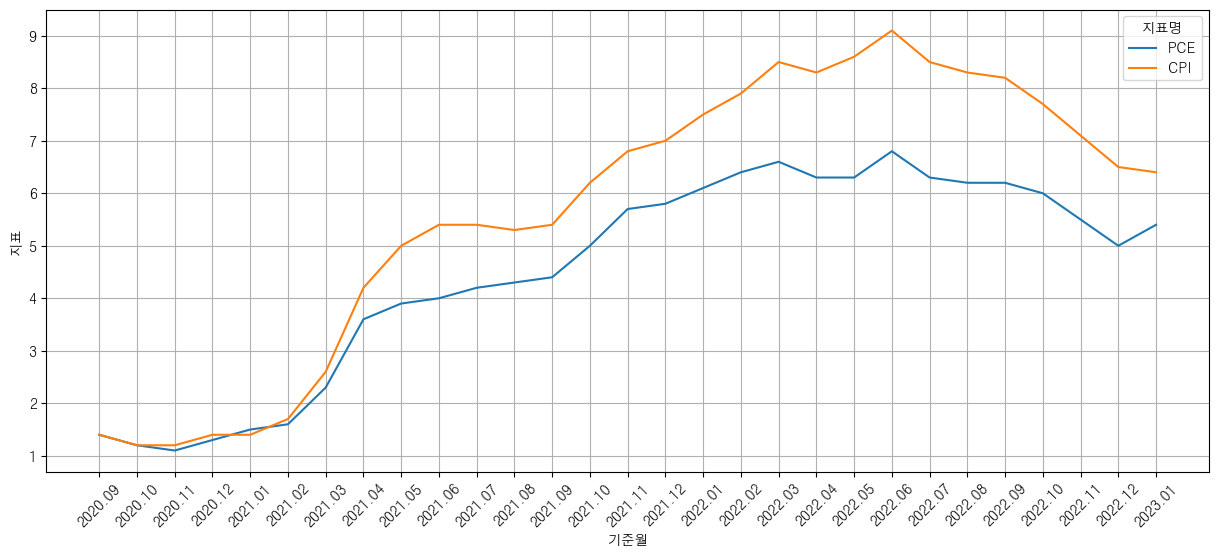

In [135]:
# seaborn 이용하여 chart 그리기
plt.figure(figsize=(15,6))
plt.xticks(rotation = 45)
plt.grid(visible=True)
sns.lineplot(data=df, x='기준월', y='지표', hue='지표명')
 

In [141]:
df.loc[df['기준월'] == '2023.01']

,기준월,지표명,지표
28,2023.01,PCE,5.4
57,2023.01,CPI,6.4
